In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
new_False = pd.read_csv("/content/drive/MyDrive/Crash Prediction RA/data/1heldoutPred_expID4_7.0335328578948975DecThresh_FalsePreds_1000.0win_800.0trainahead_0testahead.csv")

In [ ]:
new_True = pd.read_csv("/content/drive/MyDrive/Crash Prediction RA/data/1heldoutPred_expID4_7.0335328578948975DecThresh_TruePreds_1000.0win_800.0trainahead_0testahead.csv")

In [ ]:
new_False

,velocity_InTrain,velocity_cal,position_InTrain,joystick_InTrain,destabilizing_InTrain,trial_key,person,start_seconds,end_seconds,label,episode_id,predicted,lookahead_avg_destab_mag_ico,lookahead_avg_destab_mag_eco,lookahead_total_destab_steps_ico,lookahead_total_destab_steps_eco,lookahead_destab_sustained_ico,lookahead_destab_sustained_eco,lookahead_vel,lookahead_pos,lookahead_joy,lookahead_times
0,"[6.673319, 7.529687781954905, 8.17473915714288...","[9.475708007812704, 8.38370525086892, 8.783331...","[9.6624755859375, 9.832536510955128, 10.010722...","[-0.031738, -0.031738, -0.031738, -0.031738, -...","[False, False, False, False, False, False, Fal...",1_af_P26/10_600back_Block3_trial_010.csv,1_af_P26,10.318,11.312,1,229,0.0,NaN,NaN,0,0,0.000,0.000,[ 21.25377 23.034752 22.444668 25.073226 ...,[21.42883301 21.78039551 22.17315674 22.546691...,[-0.158722 -0.126953 -0.119019 -0.111084 -0.10...,[11.312 11.333 11.352 11.373 11.393 11.414 11....
1,"[-11.930435, -11.807069056365386, -14.20073048...","[-1.0118986430946215, -1.6714995118343514, -2....","[52.4432373046875, 52.40902380762577, 52.35215...","[-0.619019, -0.619019, -0.619019, -0.619019, -...","[False, False, False, False, False, False, Fal...",1_af_P26/16_600back_Block4_trial_016.csv,1_af_P26,22.158,23.144,1,322,0.0,NaN,NaN,0,0,0.000,0.000,[10.149453 13.87235 16.109306 19.746372 22.01...,[33.00018311 32.80517578 32.64587402 32.533264...,[-0.031738 -0.031738 -0.031738 -0.031738 -0.03...,[23.144 23.164 23.184 23.205 23.227 23.247 23....
2,"[-4.248608, -5.234902128942405, -4.21304940000...","[-6.931849888399654, -6.068349415958236, -6.79...","[-46.9912719726563, -47.112468089597385, -47.2...","[0.4923399999999999, 0.4994102977736543, 0.500...","[False, False, False, False, False, False, Fal...",1_ak_P6/08_600back_Block2_trial_008.csv,1_ak_P6/,76.159,77.150,1,619,0.0,0.008057,0.008057,1,1,0.000,0.000,[ 18.807601 21.538083 19.993135 22.299829 ...,[-49.07043457 -48.82873535 -48.58978271 -48.33...,[ 0.584656 0.538483 0.446198 0.376953 0.24...,[77.15 77.171 77.19 77.211 77.233 77.253 77....
3,"[24.349031, 25.944289315398894, 26.11212872170...","[7.240988991477778, 9.897145518848273, 10.6783...","[-29.528503417968803, -29.328120130776075, -29...","[0.415405, 0.392334, 0.392334, 0.3648903498542...","[False, False, False, False, False, False, Fal...",1_ak_P6/20_600back_Block5_trial_020.csv,1_ak_P6/,18.981,19.973,1,883,0.0,0.008057,0.008057,2,2,0.020,0.020,[-46.691775 -46.691775 -46.090962 -45.74764 -...,[-21.88201904 -22.50274658 -23.15093994 -23.85...,[ 0.253876 0.292358 0.292358 0.292358 0.26...,[19.973 19.993 20.014 20.034 20.055 20.077 20....
4,"[-5.278574, -5.432877811688317, -5.55294436920...","[-3.707885742187579, -3.517109701536256, -3.89...","[-1.790771484375, -1.8598997438108786, -1.9377...","[0.007843, 0.0008208961038958882, 3.1e-05, 3.1...","[False, False, False, False, False, False, Fal...",1_am_P15/01_600back_Block1_trial_001.csv,1_am_P15,19.946,20.915,1,1030,0.0,0.061043,0.061043,21,21,0.394,0.394,[ 64.598157 68.610731 71.121272 73.824932 ...,[-3.50738525 -2.75482178 -1.92260742 -1.051940...,[ 3.59406e-01 2.89093e-01 2.03156e-01 1.640...,[20.915 20.937 20.958 20.978 20.998 21.02 21....
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,"[-49.266689, -49.673319903790215, -52.84903657...","[-29.463334517038, -33.0233912435273, -32.3571...","[45.626220703125, 44.96519928423358, 44.323173...","[-0.714264, -0.714264, -0.714264, -0.689009343...","[False, False, False, False, False, False, Fal...",2_xz_P11/17_600back_Block5_trial_017.csv,2_xz_P11,105.641,106.616,0,21390,1.0,NaN,NaN,0,0,0.000,0.000,[66.2343 67.140884 68.562451 68.342511 68.51...,[23.00537109 23.89251709 24.77416992 25.768432...,[-0.150787 -0.214264 -0.301575 -0.39679 -0.44...,[106.616 106.638 106.66 106.682 106.702 106.7...
2221,"[-0.514983, -0.514983, -0.514983, -0.514983, -...","[0.2746582031248595, 0.13746923329882008, 0.01...","[0.3350830078125, 0.337826787209

In [ ]:
data = new_False.iloc[390]  #False negative
# data = new_Flase.iloc[13]  #False positive
# data = new_True.iloc[4]   #True positive
# data = new_True.iloc[5010]   #Truen negative
data

velocity_InTrain                    [31.537333, 28.221353750242628, 25.81221511953...
velocity_cal                        [54.93164062498423, 47.56278174726279, 41.4975...
position_InTrain                    [-29.374694824218803, -28.426654248473834, -27...
joystick_InTrain                    [-0.007935, -0.007935, -0.007935, -0.007935, -...
destabilizing_InTrain               [False, False, False, False, False, False, Fal...
trial_key                                    1_de_P30/10_600back_Block3_trial_010.csv
person                                                                       1_de_P30
start_seconds                                                                  67.715
end_seconds                                                                    68.692
label                                                                               0
episode_id                                                                       4306
predicted                                             

In [ ]:
def extract_destabilize(feature_matrix: np.ndarray, single_entry=True) -> np.ndarray:
    """
    generate destabilization column based on the base feature matrix of (sampling_rate, 3).
    Destabilizing is defined as all 3 basic features 1) are non zero and 2) have same direction (i.e. sign)
    :param feature_matrix: feature matrix of original (velocity, position, joystick) tuple
    :param single_entry: whether the feature matrix is single entry, of shape (sampling_rate, 3), or multi entry,
    of shape (sample_size, sampling_rate, 3)
    :return: a (sampling_rate, 1) column of boolean, indicating if row is destabilizing
    """
    # get signs of each element in matrix (0 will get nan).
    # Note that nan != nan, and this works with our definition since we don't destabilizing involves only non-zeros
    with np.errstate(divide="ignore", invalid="ignore"):
        signs = feature_matrix / np.abs(feature_matrix)

    if single_entry:
        # get booleans of whether all columns have same sign value as 1st (i.e. all same sign)
        # same_sign shape: (sampling_rate, 3)
        same_sign = np.equal(signs, signs[:, 0:1])
        # sum up booleans, only destabilizing when all 3 columns in a row are true (i.e. row sums to 3)
        num_feats = feature_matrix.shape[1]
        # return shape: (sampling_rate,)
        return np.equal(same_sign.sum(axis=1), num_feats)
    else:
        # get booleans of whether all columns have same sign value as 1st (i.e. all same sign)
        # same_sign shape: (sample_size, sampling_rate, 3)
        same_sign = np.equal(signs, signs[:, :, 0:1])
        # sum up booleans, only destabilizing when all 3 columns in a row are true (i.e. row sums to 3)
        num_feats = feature_matrix.shape[2]
        # return shape: (sample_size, sampling_rate)
        return np.equal(same_sign.sum(axis=2), num_feats)


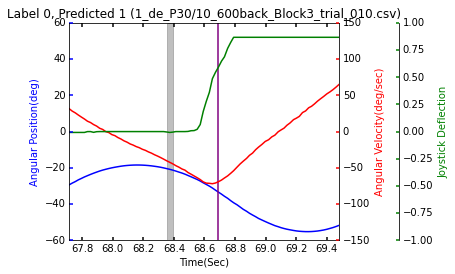

In [ ]:
#data preprocessing
def dataProcessing(data) :
  label = int(data['label'])
  predicted = int(data['predicted'])
  trial_key = data['trial_key']

  destablizing = data['destabilizing_InTrain']
  destablizing = destablizing[1: -1]
  destablizing = np.array(destablizing.split(","))
  
  vel_train = data['velocity_InTrain']
  pos_train = data['position_InTrain']
  jstick_train = data['joystick_InTrain']
  vel_train = eval(vel_train)
  pos_train = eval(pos_train)
  jstick_train = eval(jstick_train)
  
  lookahead_vel_train = np.fromstring(data["lookahead_vel"][1:-1], sep=" ")
  lookahead_pos_train = np.fromstring(data["lookahead_pos"][1:-1], sep=" ")
  lookahead_joy_train = np.fromstring(data["lookahead_joy"][1:-1], sep=" ")
  lookahead_times_train = np.fromstring(data['lookahead_times'][1:-1], sep=" ")
  # create destablizing column for lookahead time period
  feature_matrix = np.vstack((lookahead_vel_train , lookahead_pos_train ))
  feature_matrix = np.vstack((feature_matrix , lookahead_joy_train ))
  feature_matrix = np.transpose(feature_matrix)
  result = extract_destabilize(feature_matrix)

  # concatenate all destablizing
  full_destablizing = np.concatenate((destablizing, result), axis=None)
  full_destablizing

  start_input = data['start_seconds']
  end_input = data['end_seconds']
  # create x-axis values
  x = np.linspace(start_input, end_input, num=50)

  #concatenate the lookahead x and y columns with input window ones
  x = np.concatenate((x, lookahead_times_train), axis=None)
  vel_train = np.concatenate((vel_train, lookahead_vel_train), axis=None)
  pos_train = np.concatenate((pos_train, lookahead_pos_train), axis=None)
  jstick_train = np.concatenate((jstick_train, lookahead_joy_train), axis=None)

  ax = host_subplot(111, axes_class=AA.Axes)
  plt.subplots_adjust(right=0.75)

  twin1 = ax.twinx()
  twin2 = ax.twinx()
  offset1 = 0.1
  new_fixed_axis = twin1.get_grid_helper().new_fixed_axis
  twin1.axis["right"] = new_fixed_axis(loc="right", axes=twin1,
                                          offset=(offset1, 0))
  offset = 60
  new_fixed_axis = twin2.get_grid_helper().new_fixed_axis
  twin2.axis["right"] = new_fixed_axis(loc="right", axes=twin2,
                                          offset=(offset, 0))

  twin2.axis["right"].toggle(all=True)

  p1, = ax.plot(x, pos_train, "b-", label="Density")
  p2, = twin1.plot(x, vel_train, "r-", label="Angular Velocity(deg/sec)")
  p3, = twin2.plot(x, jstick_train, "g-", label="Joystick Deflection")

  ax.set_xlim(x[0], x[len(x)-1])
  ax.set_ylim(-60, 60)
  twin1.set_ylim(-150, 150)
  twin2.set_ylim(-1, 1)


  plt.title(f"Label {label}, Predicted {predicted} ({trial_key})")
  ax.set_xlabel("Time(Sec)")
  ax.set_ylabel("Angular Position(deg)")
  twin1.set_ylabel("Angular Velocity(deg/sec)")
  twin2.set_ylabel("Joystick Deflection")

  ax.yaxis.label.set_color(p1.get_color())
  twin1.yaxis.label.set_color(p2.get_color())
  twin2.yaxis.label.set_color(p3.get_color())

  tkw = dict(size=4, width=1.5)
  ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
  twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
  twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
  ax.tick_params(axis='x', **tkw)
  plt.axvline(x = lookahead_times_train[0], color = 'purple', label = 'lookahead start')

  def findPeriod(jstick,time):
    start = 9999
    end = 0
    for i in range(0,len(jstick)-2):
      if (jstick[i]=="True" or jstick[i]==" True") and start > time[i]:
        start = time[i]
      if (jstick[i]=="True" or jstick[i]==" True") and (jstick[i+1]=="False" or jstick[i+1]==" False" or i==len(jstick)-1) and end < time[i]:
        end = time[i]
        ax.axvspan(start, end, alpha=0.5, color='grey')
        start = 9999
        end =0
      
      

  findPeriod(full_destablizing,x)
  plt.show()

dataProcessing(data)